# Imports

Please use the provided `hds_stoch` environment for this work.  

In [1]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt
import simpy
from joblib import Parallel, delayed
#from treat_sim.distributions import Exponential, Lognormal

# Distribution classes

To help you build your model, the notebook includes some pre-written distribution classes that you may wish to use to setup sampling.  You are free to use these, but you can choose not too if you have an approach you prefer. 

In [2]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

class Lognormal:
    """
    Encapsulates a lognormal distirbution
    """
    def __init__(self, mean, stdev, random_seed=None):
        """
        Params:
        -------
        mean = mean of the lognormal distribution
        stdev = standard dev of the lognormal distribution
        """
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v
        source: https://blogs.sas.com/content/iml/2014/06/04/simulate-lognormal
        -data-with-specified-mean-and-variance.html

        Params:
        -------
        m = mean of lognormal distribution
        v = variance of lognormal distribution
                
        Returns:
        -------
        (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        """
        Sample from the normal distribution
        """
        return self.rand.lognormal(self.mu, self.sigma)

# Utility functions

In [3]:
def trace(msg):
    '''
    Utility function for printing simulation
    set the TRACE constant to FALSE to 
    turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

# Model parameters

The constants below provides hard coded data representing the base case or 'as-is' state of the minor injury unit.   

In [49]:
# These are the parameters for a base case model run.

# run length in days
RUN_LENGTH = 365

DEFAULT_WARMUP_AUDIT_INTERVAL = 1

# default № of reps for multiple reps run
DEFAULT_N_REPS = 5

# default random number SET
DEFAULT_RNG_SET = None
N_STREAMS = 10

# Turn off tracing
TRACE = False

# resource counts
N_BEDS = 7

# time between arrivals in minutes (exponential)
# for acute stroke, TIA and neuro respectively
MEAN_IATs = [1.2, 9.5, 3.5]

# treatment (lognormal)
# for acute stroke, TIA and neuro respectively
TREAT_MEANs = [7.4, 1.8, 2.0]
TREAT_STDs = [8.5, 2.3, 2.5]

# Scenario class
In the cell below the parameters you will find a `Scenario` class.  This makes use of the default parameters to set up the base case scenario.  Remember that its good practice to pass all of your parameters to your simulation model in a **container**.  A class is a flexible way to achieve this aim.

In [5]:
class Scenario:
    '''
    Parameter container class for minor injury unit model.
    '''
    def __init__(self, random_number_set=DEFAULT_RNG_SET):
        '''
        The init method sets up our defaults. 
        
        Params:
        -------
        
        name - str or None
            optional name for scenario
        '''
        
        # warm-up
        self.warm_up = 0.0
        
        # either hard-coded or obtained from streamlit
        self.iat_means = MEAN_IATs
        self.treat_means = TREAT_MEANs
        self.treat_stds = TREAT_STDs

        # sampling
        self.random_number_set = random_number_set
        self.init_sampling()
        
        # number of beds
        self.beds = N_BEDS
        
        
    def set_random_no_set(self, random_number_set):
        '''
        Controls the random sampling 

        Parameters:
        ----------
        random_number_set: int
            Used to control the set of psuedo random numbers
            used by the distributions in the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()
        
        
    def init_sampling(self):
        '''
        Create the distributions used by the model and initialise 
        the random seeds of each.
        '''
        # create random number streams
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0, 999999999, size=N_STREAMS)
        
        
        # inter-arrival distributions samples
        self.arrival_dist_samples = {
            'stroke': Exponential(self.iat_means[0], random_seed=self.seeds[0]),
            'tia': Exponential(self.iat_means[1], random_seed=self.seeds[1]),
            'neuro': Exponential(self.iat_means[2], random_seed=self.seeds[2])
        }
        
        # treatment distributions samples
        self.treatment_dist_samples = {
            'stroke': Lognormal(self.treat_means[0], self.treat_stds[0], random_seed=self.seeds[3]),
            'tia': Lognormal(self.treat_means[1], self.treat_stds[1], random_seed=self.seeds[4]),
            'neuro': Lognormal(self.treat_means[2], self.treat_stds[2], random_seed=self.seeds[5])
        }
            
        

# Model building

In [6]:
class Patient:
    '''
    Patient in the minor ED process
    '''
    def __init__(self, identifier, patient_type, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        # patient id and environment
        self.identifier = identifier
        self.env = env
        
        # treatment parameters
        self.patient_type = patient_type
        self.beds = args.beds
        self.treatment_dist_samples = args.treatment_dist_samples
                
        # individual patient metrics
        self.queue_time = 0.0
        self.treat_time = 0.0
        
    def get_treatment_dist_sample(self):

        # sample for patient pathway
        if self.patient_type == 'stroke':
            self.treat_time = self.treatment_dist_samples['stroke'].sample()
        elif self.patient_type == 'tia':
            self.treat_time = self.treatment_dist_samples['tia'].sample()
        else:
            self.treat_time = self.treatment_dist_samples['neuro'].sample()  
                
        activity_duration = self.treat_time
            
        return activity_duration
        
    
    def treatment(self):

        # record the time that patient entered the system
        arrival_time = self.env.now
     
        # get a bed
        with self.beds.request() as req:
            yield req
            
            # record time to first being seen by a doctor
            self.queue_time = self.env.now - arrival_time
            
            
            trace(f'Patient № {self.identifier} started treatment at {self.env.now:.3f};' 
                 + f' queue time was {self.queue_time:.3f}') 
            
            
            # treatment delay
            yield self.env.timeout(self.get_treatment_dist_sample())
            
            self.patient_discharged()
    
    def patient_discharged(self):
        
        trace(f'Patient № {self.identifier} discharged at {self.env.now:.3f}')

In [7]:
class MonitoredPatient(Patient):
    '''
    Monitor a Patient.  Inherits from Patient
    Implemented using the observer design pattern
    
    A MonitoredPatient notifies its observers that a patient
    process has reached an event 
    1. completing treatment
    '''
    def __init__(self, admissions_count, patient_type, env, args, model):
        '''
        Constructor
        
        Params:
        -------
        patient: Patient
            patient process to monitor
            
        auditor: Auditor
            auditor
        '''
        super().__init__(admissions_count, patient_type, env, args)
        self._observers = [model]
        
    def register_observer(self, observer):
        self._observers.append(observer)
    
    def notify_observers(self, *args, **kwargs):
        for observer in self._observers: 
            observer.process_event(*args, **kwargs)
    
    def patient_discharged(self):
        super().patient_discharged()
        
        # passes the patient (self) and a message
        self.notify_observers(self, 'patient_discharged')


In [45]:
class ASU:  
    '''
    Model of an ASU
    '''
    def __init__(self, args):
        '''
        Contructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = simpy.Environment()
        self.args = args 
        self.init_model_resources(args)
        self.patients = []
        
        self.admissions_count = 0
        
        self.stroke_count = 0
        self.tia_count = 0
        self.neuro_count = 0
        
        #running performance metrics:
        self.bed_wait = 0.0
        self.bed_util = 0.0
        
        self.patient_count = 0
            
        self.bed_occupation_time = 0.0
        
        
    def init_model_resources(self, args):
        '''
        Setup the simpy resource objects
        
        Params:
        ------
        args - Scenario
            Simulation Parameter Container
        '''

        args.beds = simpy.Resource(self.env, 
                                   capacity=args.beds)
        
        
    def run(self, results_collection_period = RUN_LENGTH,
            warm_up = 0):
        '''
        Conduct a single run of the model in its current 
        configuration

        run length = results_collection_period + warm_up

        Parameters:
        ----------
        results_collection_period, float, optional
            default = RUN_LENGTH

        warm_up, float, optional (default=0)
            length of initial transient period to truncate
            from results.

        Returns:
        --------
            None

        '''
        # setup the arrival processes
        self.env.process(self.arrivals_generator('stroke'))
        self.env.process(self.arrivals_generator('tia'))
        self.env.process(self.arrivals_generator('neuro'))
                
        # run
        self.env.run(until=results_collection_period+warm_up)
        
        
    def get_arrival_dist_sample(self):
        
        if self.patient_type == 'stroke':
            inter_arrival_time = self.args.arrival_dist_samples['stroke'].sample()
        elif self.patient_type == 'tia':
            inter_arrival_time = self.args.arrival_dist_samples['tia'].sample()
        else:
            inter_arrival_time = self.args.arrival_dist_samples['neuro'].sample()
        
        return inter_arrival_time
            
        
    def arrivals_generator(self, patient_type):
        self.args.init_sampling()
            
        while True:
                
                self.patient_type = patient_type
            
                if self.patient_type == 'stroke':
                    self.stroke_count += 1
                elif self.patient_type == 'tia':
                    self.tia_count += 1
                else:
                    self.neuro_count += 1    

                iat = self.get_arrival_dist_sample()
                yield self.env.timeout(iat)
                
                self.admissions_count += 1

                trace(f'Patient № {self.admissions_count} ({patient_type}) arrives at {self.env.now:.3f}')
                
                # create a new patient and pass in env and args
                new_patient = MonitoredPatient(self.admissions_count, patient_type, self.env, self.args, self)                

                # init the minor injury process for this patient
                self.env.process(new_patient.treatment())                 
                
                
                if self.env.now > self.args.warm_up:
                    
                    # keep a record of the patient for results calculation
                    self.patients.append(new_patient)                
    
    
    
    def process_event(self, *args, **kwargs):
        '''
        Running calculates each time a Patient process ends
        (when a patient departs the simulation model)
        
        Params:
        --------
        *args: list
            variable number of arguments. This is useful in case you need to
            pass different information for different events
        
        *kwargs: dict
            keyword arguments.  Same as args, but you can is a dict so you can
            use keyword to identify arguments.
        
        '''
        patient = args[0]
        msg = args[1]
        
        #only run if warm up complete
        if self.env.now < self.args.warm_up:
            return

        if msg == 'patient_discharged':
            self.patient_count += 1
            n = self.patient_count
            
            #running calculation for mean bed waiting time
            self.bed_wait += \
                (patient.queue_time - self.bed_wait) / n

            #running calc for mean bed utilisation
            self.bed_occupation_time += patient.treat_time

                
                
    def run_summary_frame(self):
        
        '''
        Utility function for final metrics calculation.
        
        Returns df containining
        total pts count
        count of each of pts types
        bed utilisation
        mean waiting time of bottom 90% of pts
        % of pts admitted in <4 hours
        '''
        
        # adjust util calculations for warmup period
        rc_period = self.env.now - self.args.warm_up
        util = self.bed_occupation_time / (rc_period * self.args.beds.capacity)
        
        
        
        # create nparray of all queue times, convert to hours
        patients_queue_times = np.array([patient.queue_time * 24 for patient in self.patients])
        
        #sort array in descending order, drops top 10% of values, calculate the mean 
        queue_bottom90 = np.mean(np.sort(patients_queue_times)[len(self.patients) // 10:])
        
        
        
        
        # calculate proportion of patient with queue time less than 4 hrs
        percent_4_less = (sum(qt <= 4 for qt in patients_queue_times) / len(self.patients)) * 100
        
        

        
        
        average_treat_time = np.array([patient.treat_time 
                     for patient in self.patients]).sum() / self.patient_count
        

        df = pd.DataFrame({'1':{'1b Stroke Patient Arrivals':self.stroke_count,
                                '2 Bottom 90% Mean Treatment Waiting Time (hrs)': queue_bottom90, 
                                '4 Bed Utilisation (%)': util*100,
                                '1a Total Patient Arrivals':self.patient_count,
                                '1d Neuro Patient Arrivals':self.neuro_count,
                                '1c TIA Patient Arrivals':self.tia_count,
                                '5 Mean Total Time in Unit per patient(hrs)':average_treat_time,
                                '3 Patients Admitted to Unit within 4 hrs of arrival(%)': percent_4_less}})
        
        
        df = df.T
        df.index.name = 'rep'
        return df

# Functions for single and multiple runs

In [9]:
def single_run(scenario, 
               rc_period = RUN_LENGTH, 
               warm_up = 0,
               random_no_set = DEFAULT_RNG_SET):
    '''
    Perform a single run of the model and return the results
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    rc_period: int
        The length of the simulation run that collects results
        
    warm_up: int, optional (default=0)
        warm-up period in the model.  The model will not collect any results
        before the warm-up period is reached.  
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    Returns:
    --------
        pandas.DataFrame:
        results from single run.
    '''  
        
    # set random number set - this controls sampling for the run.
    if random_no_set is not None:
        scenario.set_random_no_set(random_no_set)
    
    # create the model
    model = ASU(scenario)

    model.run(results_collection_period = rc_period, warm_up = warm_up)
    
    # run the model
    results_summary= model.run_summary_frame()
    
    return results_summary

In [10]:
def multiple_replications(scenario, 
                          rc_period=RUN_LENGTH,
                          warm_up=0,
                          n_reps=DEFAULT_N_REPS, 
                          n_jobs=-1,
                          random_no_set = DEFAULT_RNG_SET):
    '''
    Perform multiple replications of the model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: float, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        results collection period.  
        the number of minutes to run the model beyond warm up
        to collect results
    
    warm_up: float, optional (default=0)
        initial transient period.  no results are collected in this period

    n_reps: int, optional (default=DEFAULT_N_REPS)
        Number of independent replications to run.

    n_jobs, int, optional (default=-1)
        No. replications to run in parallel.
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model.  Set to different ints to get different results.  Set to None
        for a random set of seeds.
        
    Returns:
    --------
    List
    '''    
    
    
    if random_no_set is not None:
        rng_sets = [random_no_set + rep for rep in range(n_reps)]
    else:
        rng_sets = [None] * n_reps
        
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(scenario, 
                                                      rc_period, 
                                                      warm_up, 
                                                      random_no_set=rng_set) 
                                    for rng_set in rng_sets)
    

    # format and return results in a dataframe
    df_results = pd.concat(res)
    df_results.index = np.arange(1, len(df_results)+1)
    df_results.index.name = 'rep'
    return df_results


# Scripts to run the model

In [46]:
# SINGLE RUN

# base case scenario with default parameters
default_args = Scenario()

print('Running simulation ...', end = ' => ')
results = single_run(default_args, warm_up=250)
print('simulation complete.')

results

Running simulation ... => simulation complete.


,1a Total Patient Arrivals,1b Stroke Patient Arrivals,1c TIA Patient Arrivals,1d Neuro Patient Arrivals,2 Bottom 90% Mean Treatment Waiting Time (hrs),3 Patients Admitted to Unit within 4 hrs of arrival(%),4 Bed Utilisation (%),5 Mean Total Time in Unit per patient(hrs)
rep,,,,,,,,
1,710.0,485.0,64.0,167.0,0.698742,97.896213,56.951671,5.501885


In [51]:
# MULTIPLE RUN

# default scenario
args = Scenario()

# run multiple replications.
# by default it runs 5 replications.
print('Running multiple replications', end=' => ')
results  = multiple_replications(args, n_reps=10, warm_up=250)
print('done.\n')

# show reps rounded to 2dp
results.round(2)

Running multiple replications => done.



,1a Total Patient Arrivals,1b Stroke Patient Arrivals,1c TIA Patient Arrivals,1d Neuro Patient Arrivals,2 Bottom 90% Mean Treatment Waiting Time (hrs),3 Patients Admitted to Unit within 4 hrs of arrival(%),4 Bed Utilisation (%),5 Mean Total Time in Unit per patient(hrs)
rep,,,,,,,,
1,712.0,532.0,77.0,173.0,340.26,20.80,94.50,5.82
2,686.0,507.0,71.0,165.0,939.07,11.76,97.05,6.27
3,763.0,522.0,91.0,190.0,231.15,17.25,95.86,5.54
4,774.0,545.0,66.0,191.0,391.94,4.38,98.12,5.51
5,726.0,515.0,74.0,151.0,204.25,28.90,89.55,5.47
6,690.0,502.0,61.0,160.0,115.46,30.69,91.21,5.82
7,736.0,526.0,78.0,173.0,787.91,8.14,98.30,5.87
8,732.0,520.0,59.0,168.0,229.65,14.78,93.22,5.57
9,705.0,501.0,57.0,170.0,235.85,19.59,90.25,5.73


In [50]:
results.mean() #11 beds

1a Total Patient Arrivals                                 733.400000
1b Stroke Patient Arrivals                                506.400000
1c TIA Patient Arrivals                                    66.800000
1d Neuro Patient Arrivals                                 170.600000
2 Bottom 90% Mean Treatment Waiting Time (hrs)              4.058974
3 Patients Admitted to Unit within 4 hrs of arrival(%)     90.539446
4 Bed Utilisation (%)                                      61.790202
5 Mean Total Time in Unit per patient(hrs)                  5.857853
dtype: float64

In [52]:
results.mean() #7 beds

1a Total Patient Arrivals                                 725.600000
1b Stroke Patient Arrivals                                516.800000
1c TIA Patient Arrivals                                    70.000000
1d Neuro Patient Arrivals                                 171.600000
2 Bottom 90% Mean Treatment Waiting Time (hrs)            363.373473
3 Patients Admitted to Unit within 4 hrs of arrival(%)     18.006638
4 Bed Utilisation (%)                                      93.828841
5 Mean Total Time in Unit per patient(hrs)                  5.695386
dtype: float64

In [14]:
class WarmupAuditor():
    '''
    Warmup Auditor for the model.
    
    Stores the cumulative means for:
    1. bed waiting time
    2. bed utilisation.
    
    '''
    def __init__(self, model, interval=DEFAULT_WARMUP_AUDIT_INTERVAL):
        self.env = model.env
        self.model = model
        self.interval = interval
        self.bed_wait = []
        self.bed_util = []
        
    def run(self, rc_period):
        '''
        Run the audited model
        
        Parameters:
        ----------
        rc_period: float
            Results collection period.  Typically this should be many times
            longer than the expected results collection period.
            
        Returns:
        -------
        None.
        '''
        # set up data collection for warmup variables.
        self.env.process(self.audit_model())
        self.model.run(rc_period, 0)
        
    def audit_model(self):
        '''
        Audit the model at the specified intervals
        '''
        for i in itertools.count():
            yield self.env.timeout(self.interval)

            
            # Performance metrics
            # calculate the utilisation metrics
            util = self.model.bed_occupation_time / \
                (self.env.now * self.model.args.beds.capacity)
            
            
            # store the metrics
            self.bed_wait.append(self.model.bed_wait)
            self.bed_util.append(util)

            
    def summary_frame(self):
        '''
        Return the audit observations in a summary dataframe
        
        Returns:
        -------
        pd.DataFrame
        '''
        
        df = pd.DataFrame([self.bed_wait,
                           self.bed_util]).T
        df.columns = ['bed_wait', 'bed_util']
        
        return df

    
def warmup_single_run(scenario, rc_period, 
                      interval=DEFAULT_WARMUP_AUDIT_INTERVAL, 
                      random_no_set=DEFAULT_RNG_SET):
    '''
    Perform a single run of the model as part of the warm-up
    analysis.
    
    Parameters:
    -----------
    
    scenario: Scenario object
        The scenario/paramaters to run
        
    results_collection_period: int
        The length of the simulation run that collects results
               
    audit_interval: int, optional (default=60)
        during between audits as the model runs.
        
    Returns:
    --------
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''        
    
    # set random number set - this controls sampling for the run.
    if random_no_set is not None:
        scenario.set_random_no_set(random_no_set)

    # create an instance of the model
    model = ASU(scenario)

    # create warm-up model auditor and run
    audit_model = WarmupAuditor(model, interval)
    audit_model.run(rc_period)

    return audit_model.summary_frame()


def warmup_analysis(scenario, rc_period, n_reps=DEFAULT_N_REPS,
                    interval=DEFAULT_WARMUP_AUDIT_INTERVAL,
                    n_jobs=-1):
                   # random_no_set=DEFAULT_RNG_SET):
    '''
    Conduct a warm-up analysis of key performance measures in the model.
    
    The analysis runs multiple replications of the model.
    In each replication a WarmupAuditor periodically takes observations
    of the following metrics:

    metrics included:
    1. Operator waiting time
    2. Nurse callback waiting time
    3. Operator utilisation
    4. Nurse utilisation

    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    rc_period: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.

    n_jobs: int, optional (default=-1)
        Number of processors for parallel running of replications

    Returns:
    --------
    dict of pd.DataFrames where each dataframe related to a metric.
    Each column of a dataframe represents a replication and each row 
    represents an observation.
    '''    
    
    res = Parallel(n_jobs=n_jobs)(delayed(warmup_single_run)(scenario, 
                                                             rc_period,
                                                             random_no_set=rep,
                                                             interval=interval) 
                                  for rep in range(n_reps))
       
    # format and return results
    metrics = {'bed_wait':[],
               'bed_util':[]}

    # preprocess results of each replication
    for rep in res:
        metrics['bed_wait'].append(rep.bed_wait)
        metrics['bed_util'].append(rep.bed_util)
        
    # cast to dataframe
    metrics['bed_wait'] = pd.DataFrame(metrics['bed_wait']).T
    metrics['bed_util'] = pd.DataFrame(metrics['bed_util']).T
    
    # index as obs number
    metrics['bed_wait'].index = np.arange(1, len(metrics['bed_wait'])+1)
    metrics['bed_util'].index = np.arange(1, len(metrics['bed_util'])+1)

    # obs label
    metrics['bed_wait'].index.name = "audit"
    metrics['bed_util'].index.name = "audit"
    
    # columns as rep number
    cols = [f'rep_{i}' for i in range(1, n_reps+1)]
    metrics['bed_wait'].columns = cols
    metrics['bed_util'].columns = cols
    
    return metrics

In [39]:
%%time
# script
# note this will take 5-30 seconds to run depending on your machine

# default scenario
args = Scenario()

N_REPS=10

RUN_LENGTH=365

#run warm up analysis for scenario
print('Running warm-up analysis with replications. Please wait...', end=' => ')
results = warmup_analysis(args, rc_period=RUN_LENGTH, n_reps=N_REPS)
print('done.')

Running warm-up analysis with replications. Please wait... => done.
CPU times: user 67 ms, sys: 11.4 ms, total: 78.3 ms
Wall time: 133 ms


In [67]:
results['bed_util'].head(10)

,rep_1,rep_2,rep_3,rep_4,rep_5,rep_6,rep_7,rep_8,rep_9,rep_10,...,rep_21,rep_22,rep_23,rep_24,rep_25,rep_26,rep_27,rep_28,rep_29,rep_30
audit,,,,,,,,,,,,,,,,,,,,,
1,0.050049,0.036547,0.084152,0.092097,0.073847,0.154106,0.346337,0.051924,0.025849,0.000000,...,0.106593,0.041764,0.000000,0.039895,0.086374,0.111829,0.007193,0.000000,0.128954,0.050496
2,0.075434,0.035694,0.134806,0.160961,0.151814,0.135012,0.253088,0.138072,0.131051,0.315087,...,0.125328,0.166123,0.193727,0.110539,0.166942,0.130687,0.139202,0.086340,0.314660,0.191930
3,0.270476,0.072100,0.222696,0.278630,0.151474,0.180893,0.293149,0.196412,0.182603,0.371515,...,0.195754,0.216372,0.199750,0.229477,0.185364,0.126251,0.169179,0.152495,0.478343,0.384454
4,0.348100,0.074982,0.214623,0.325585,0.197805,0.217860,0.344260,0.214616,0.287079,0.313529,...,0.252038,0.248787,0.248818,0.296913,0.296888,0.288862,0.167271,0.146244,0.434869,0.368444
5,0.346292,0.248108,0.270608,0.479539,0.226708,0.266892,0.332609,0.259380,0.285800,0.278230,...,0.262365,0.290178,0.288896,0.273478,0.332217,0.319767,0.286444,0.221522,0.425223,0.384535
6,0.406841,0.252184,0.337266,0.667619,0.245791,0.299961,0.345367,0.249129,0.366898,0.428599,...,0.314157,0.302047,0.312933,0.232755,0.401110,0.376583,0.315580,0.322972,0.451661,0.440651
7,0.442506,0.322092,0.348183,0.599935,0.252493,0.310657,0.321369,0.230739,0.472174,0.389467,...,0.321932,0.329088,0.282049,0.278071,0.427283,0.471543,0.338441,0.316979,0.472992,0.451808
8,0.441625,0.374265,0.384283,0.563378,0.311771,0.310324,0.401170,0.356698,0.517950,0.426843,...,0.308112,0.363389,0.292062,0.262105,0.468251,0.423516,0.308664,0.321716,0.487516,0.504775
9,0.430766,0.460330,0.429633,0.550026,0.294560,0.280372,0.505700,0.342290,0.536563,0.401895,...,0.384205,0.394628,0.292723,0.254369,0.471685,0.394605,0.301884,0.301659,0.440951,0.476831


In [28]:
def time_series_inspection(results, warm_up=None):
    '''
    Time series inspection method
    
    Parameters:
    ----------
    results: dict
        The dict of results taken from warmup_analysis
    '''
    
    # create the 4 chart areas to plot
    fig, ax = plt.subplots(1, 2, figsize=(12,4.5))
    
    # take the mean of the columns for each metric and plot
    ax[0].plot(results['bed_wait'].mean(axis=1))
    ax[1].plot(results['bed_util'].mean(axis=1))

    # set the label of each chart
    ax[0].set_ylabel('bed_wait')
    ax[1].set_ylabel('bed_util')

    if warm_up is not None:
        #add warmup cut-off vertical line if one is specified
        ax[0].axvline(x=warm_up, color='red', ls='--')
        ax[1].axvline(x=warm_up, color='red', ls='--')
    
    return fig, ax

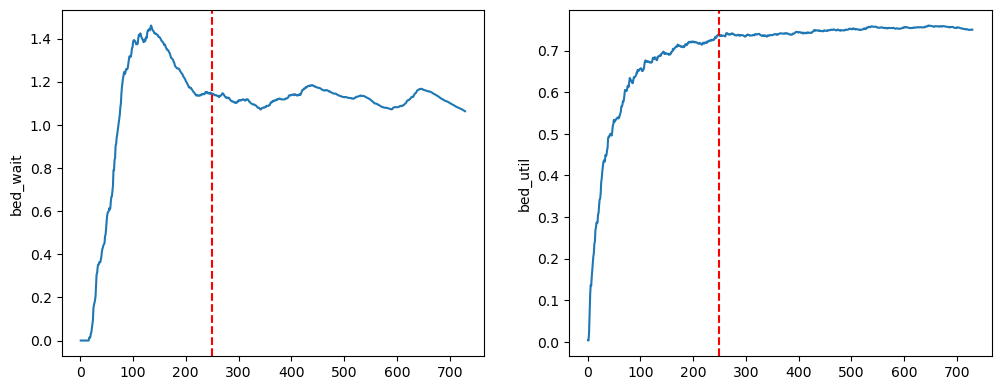

In [30]:
# this assumes you assigned the output of warmup_analysis to a varible 'results'
fig, ax = time_series_inspection(results, warm_up=250) #9 beds

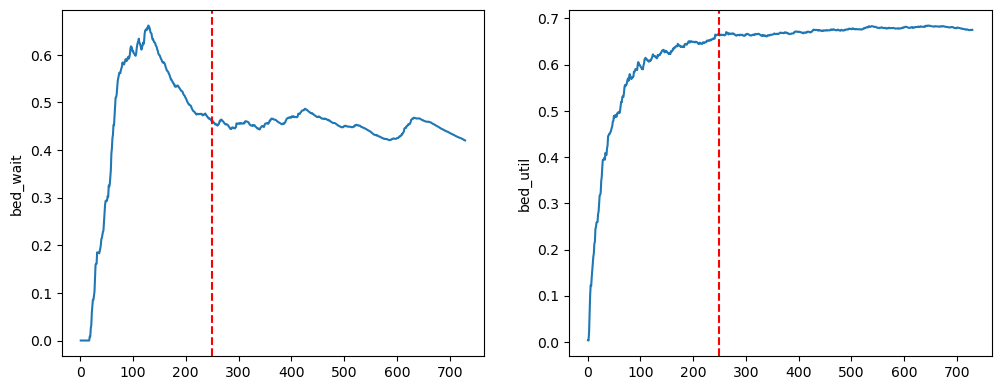

In [34]:
fig, ax = time_series_inspection(results, warm_up=250) #10 beds 10 reps

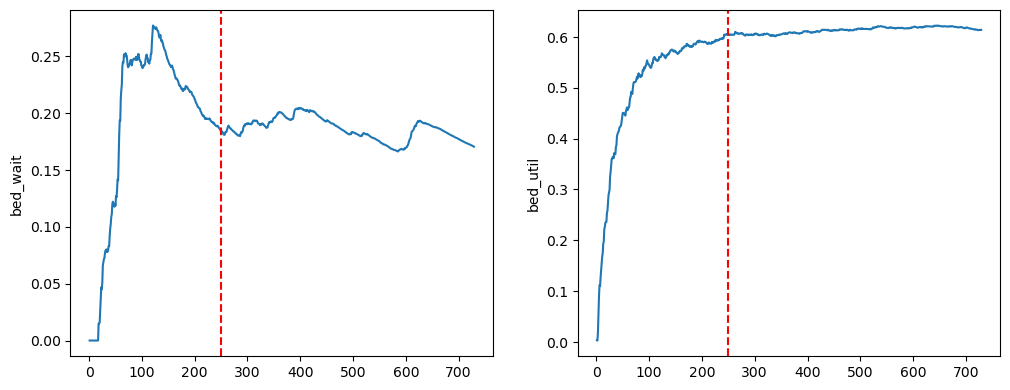

In [38]:
fig, ax = time_series_inspection(results, warm_up=250) #11 beds 30 reps

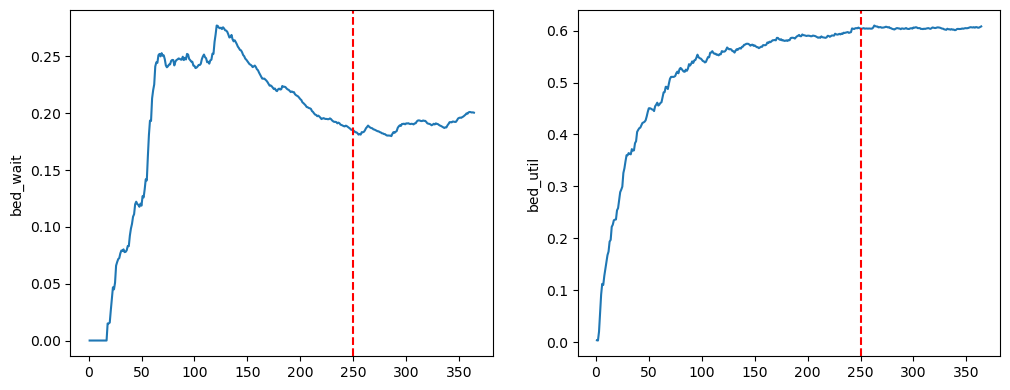

In [40]:
# this assumes you assigned the output of warmup_analysis to a varible 'results'
fig, ax = time_series_inspection(results, warm_up=250) #9 beds